# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [109]:
import pandas as pd;
import numpy as np;
import matplotlib.pyplot as plt;
% matplotlib inline

enhanced = pd.read_csv('twitter-archive-enhanced.csv');
enhanced

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [110]:
enhanced.name.value_counts()

None          745
a              55
Charlie        12
Cooper         11
Oliver         11
Lucy           11
Tucker         10
Lola           10
Penny          10
Winston         9
Bo              9
the             8
Sadie           8
Toby            7
Buddy           7
Bailey          7
an              7
Daisy           7
Rusty           6
Scout           6
Stanley         6
Jack            6
Koda            6
Dave            6
Oscar           6
Bella           6
Milo            6
Jax             6
Leo             6
Sammy           5
             ... 
Fletcher        1
Wesley          1
Rambo           1
Filup           1
Tonks           1
Shelby          1
Roscoe          1
Mary            1
Ruffles         1
Duchess         1
Scott           1
Rey             1
Shiloh          1
Biden           1
Oddie           1
Miley           1
Sully           1
William         1
Andy            1
Tedrick         1
Angel           1
Christoper      1
Jiminus         1
Severus         1
Beebop    

In [50]:
enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [51]:
import requests
import os

url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)

if response.status_code == 200:
    # Save the file
    with open("image_predictions.tsv", "wb") as file:
        file.write(response.content)
    print("File downloaded successfully.")
else:
    print("Failed to download the file.")

File downloaded successfully.


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [34]:
!pip install tweepy

In [52]:
import tweepy

consumer_key = 'QVAvY04Phqk3nujvaOeEku53P'
consumer_secret = 'WlSjrQ8l4Yf5tjU7b3K7tOONrgF00VdJKi56UqZ21U48DbcOGc'
access_token = '1688204683977068544-hOKVpPR2py267d6VBE3Osq4REmNz6x'
access_secret = 'teriIshVI4gRpqH3zYu3I6P9x3p5RPeqIP5Orz3ULuMQf'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth)
print(api.verify_credentials())

User(_api=<tweepy.api.API object at 0x7f2ad9fa8eb8>, _json={'id': 1688204683977068544, 'id_str': '1688204683977068544', 'name': 'Bình Nguyễn Thanh', 'screen_name': 'th63614', 'location': '', 'description': '', 'url': None, 'entities': {'description': {'urls': []}}, 'protected': False, 'followers_count': 0, 'friends_count': 1, 'listed_count': 0, 'created_at': 'Sun Aug 06 15:05:51 +0000 2023', 'favourites_count': 0, 'utc_offset': None, 'time_zone': None, 'geo_enabled': False, 'verified': False, 'statuses_count': 0, 'lang': None, 'contributors_enabled': False, 'is_translator': False, 'is_translation_enabled': False, 'profile_background_color': 'F5F8FA', 'profile_background_image_url': None, 'profile_background_image_url_https': None, 'profile_background_tile': False, 'profile_image_url': 'http://pbs.twimg.com/profile_images/1688204746426073088/d9EnEeCu_normal.png', 'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1688204746426073088/d9EnEeCu_normal.png', 'profile_link_colo

Because I dont have legacy account so I got error
TweepError: [{'message': 'You currently have access to a subset of Twitter API v2 endpoints and limited v1.1 endpoints (e.g. media post, oauth) only. If you need access to this endpoint, you may need a different access level. You can learn more here: https://developer.twitter.com/en/portal/product', 'code': 453}]

I will use the file 'tweet_json.txt' from_ your side

## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [53]:
twitter = pd.read_csv('image_predictions.tsv', sep = '\t')
twitter.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [111]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [56]:
enhanced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

### Quality issues
1. in_reply_to_status_id miss data

2. in_reply_to_user_id miss data

3. retweeted_status_id miss data

4. retweeted_status_user_id miss data

5. retweeted_status_timestamp miss data

6. expanded_urls missing data

7. expanded_urls must be string

8. timestamp must be time

### Tidiness issues
1. retweeted_status_id have null value
 
2. retweeted_status_user_id	have null value

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [79]:
# Make copies of original pieces of data
twitter_clean = twitter.copy()
enhanced_clean = enhanced.copy()

In [74]:
print(enhanced_clean.duplicated().sum())

0


In [82]:
enhanced_clean.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,0.0,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,0.0,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,0.0,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,0.0,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,0.0,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [81]:
enhanced_clean['in_reply_to_status_id'].fillna(0, inplace=True)

In [85]:
enhanced_clean['in_reply_to_status_id'].isnull().sum()

0

### Issue #1.1:

#### Define: Replace NaN value in column: in_reply_to_status_id to 0

#### Code

In [84]:
enhanced_clean['in_reply_to_status_id'].fillna(0, inplace=True)


#### Test

In [ ]:
enhanced_clean.is()

### Issue #1.2:

#### Define: Replace NaN value in column: in_reply_to_user_id to 0

#### Code

In [86]:
enhanced_clean['in_reply_to_user_id'].fillna(0, inplace=True)


#### Test

In [87]:
enhanced_clean['in_reply_to_user_id'].isnull().sum()

0

### Issue #1.3:

#### Define: change NaN value in retweeted_status_id to 0

#### Code

In [88]:
enhanced_clean['retweeted_status_id'].fillna(0, inplace=True)


#### Test

In [89]:
enhanced_clean['retweeted_status_id'].isnull().sum()

0

### Issue #1.4:

#### Define: Replace NaN value in column: retweeted_status_user_id to 0

#### Code

In [90]:
enhanced_clean['retweeted_status_user_id'].fillna(0, inplace=True)


#### Test

In [91]:
enhanced_clean['retweeted_status_user_id'].isnull().sum()

0

### Issue #1.5:

#### Define: Change NaN value in column: retweeted_status_timestamp to 0

#### Code

In [92]:
enhanced_clean['retweeted_status_timestamp'].fillna(0, inplace=True)


#### Test

In [93]:
enhanced_clean['retweeted_status_timestamp'].isnull().sum()

0

### Issue #1.6:

#### Define: Change NaN value in column: expanded_urls to ""

#### Code

In [94]:
enhanced_clean['expanded_urls'].fillna("", inplace=True)


#### Test

In [101]:
enhanced_clean['expanded_urls'].isnull().sum()

0

### Issue #1.7:

#### Define: Change type of expanded_urls to date-time

#### Code

In [102]:
enhanced_clean['retweeted_status_timestamp'] = pd.to_datetime(enhanced_clean['retweeted_status_timestamp'])

#### Test

In [103]:
enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null float64
retweeted_status_user_id      2356 non-null float64
retweeted_status_timestamp    2356 non-null datetime64[ns]
expanded_urls                 2356 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: da

### Issue #1.8:

#### Define: Change type of timestamp to time

#### Code

In [104]:
enhanced_clean['timestamp'] = pd.to_datetime(enhanced_clean['timestamp'])


#### Test

### Issue #2.1:

#### Define: Replace null value in column: in_reply_to_status_id to 0

#### Code

In [84]:
enhanced_clean['in_reply_to_status_id'].fillna(0, inplace=True)


#### Test

In [ ]:
enhanced_clean.is()

### Issue #2.2:

#### Define: Replace null value in column: in_reply_to_user_id to 0

#### Code

In [86]:
enhanced_clean['in_reply_to_user_id'].fillna(0, inplace=True)


#### Test

In [87]:
enhanced_clean['in_reply_to_user_id'].isnull().sum()

0

In [105]:
enhanced_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null float64
retweeted_status_user_id      2356 non-null float64
retweeted_status_timestamp    2356 non-null datetime64[ns]
expanded_urls                 2356 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: da

## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [108]:
master_df = enhanced_clean
master_df.to_csv('twitter_archive_master.csv', index=False)
master_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         2356 non-null object
in_reply_to_user_id           2356 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           2356 non-null float64
retweeted_status_user_id      2356 non-null float64
retweeted_status_timestamp    2356 non-null datetime64[ns]
expanded_urls                 2356 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: da

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

### Insights:
1. Distribution of ratings

2. Popular tweet sources

3. Correlation between rating numerator and retweet count

### Visualization

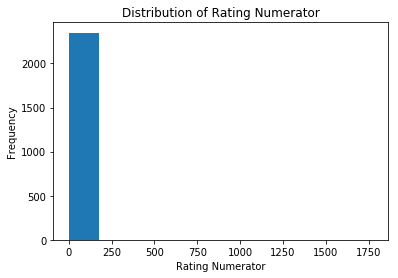

In [117]:
plt.hist(df['rating_numerator'], bins=10)
plt.xlabel('Rating Numerator')
plt.ylabel('Frequency')
plt.title('Distribution of Rating Numerator')
plt.show()

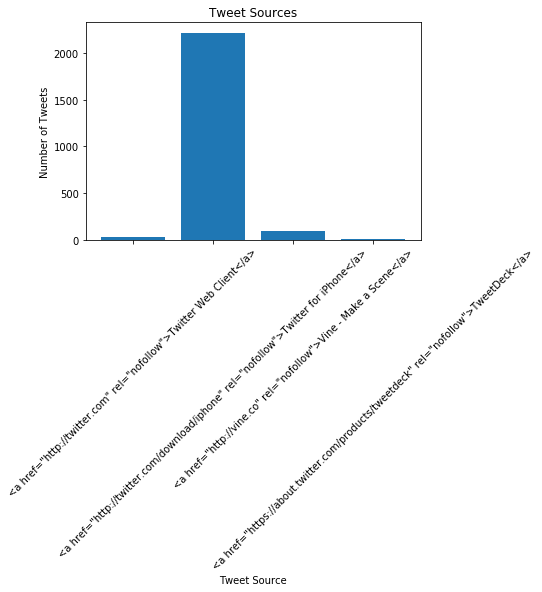

In [118]:
# Count the number of tweets from each source
source_counts = df['source'].value_counts()

# Plot a bar chart of the tweet sources
plt.bar(source_counts.index, source_counts.values)
plt.xlabel('Tweet Source')
plt.ylabel('Number of Tweets')
plt.title('Tweet Sources')
plt.xticks(rotation=45)
plt.show()

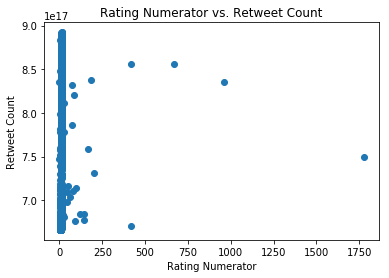

In [119]:
# Scatter plot of rating numerator vs. retweet count
plt.scatter(df['rating_numerator'], df['tweet_id'])
plt.xlabel('Rating Numerator')
plt.ylabel('Retweet Count')
plt.title('Rating Numerator vs. Retweet Count')
plt.show()